## Load the libraries

In [1]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

/Users/ejt/anaconda3/envs/code-satp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load, inspect and clean the data

In [2]:
# load data
csv_path = 'data/satp_classification.csv'
satp_df = pd.read_csv(csv_path)

# inspect data
satp_df.info()
satp_df.head()

# look at counts of original labels
satp_df['perpetrator'].value_counts() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   incident_number            9920 non-null   float64
 1   state                      9921 non-null   object 
 2   district                   9921 non-null   object 
 3   block                      5360 non-null   object 
 4   village_name               5232 non-null   object 
 5   other_areas                4026 non-null   object 
 6   constituency               7192 non-null   object 
 7   longitude                  7275 non-null   float64
 8   latitude                   7275 non-null   float64
 9   year                       9921 non-null   int64  
 10  date                       9920 non-null   object 
 11  perpetrator                9921 non-null   object 
 12  first_action               9919 non-null   object 
 13  second_action              2220 non-null   objec

perpetrator
Maoist                    5190
Security                  4263
Unknown                    461
Non-Maoist Armed Group       6
Civilians                    1
Name: count, dtype: int64

Note that `Civilian` and `Non-Maoist Armed Group` account for just a handful of observations. Let's drop these to simplify the analysis. 

In [3]:
# drop out values
satp_df = satp_df[~((satp_df['perpetrator'] == "Civilians") | (satp_df['perpetrator'] == "Non-Maoist Armed Group"))]

# look at counts of original labels again
satp_df['perpetrator'].value_counts() 

perpetrator
Maoist      5190
Security    4263
Unknown      461
Name: count, dtype: int64

Now let's convert the original labels to the same format that our candidate and predicted labels are going to be.

In [4]:
# convert original labels to same format as predicted
satp_df['original_label'] = satp_df['perpetrator'].map({
    "Security": "action undertaken by security forces",
    "Maoist": "action undertaken by maoist insurgents",
     "Unknown": "unclear who initiated action"
})

# inspect data
satp_df.info()
satp_df.shape

# look at counts of original labels
satp_df['original_label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 9914 entries, 0 to 9920
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   incident_number            9913 non-null   float64
 1   state                      9914 non-null   object 
 2   district                   9914 non-null   object 
 3   block                      5358 non-null   object 
 4   village_name               5228 non-null   object 
 5   other_areas                4025 non-null   object 
 6   constituency               7187 non-null   object 
 7   longitude                  7270 non-null   float64
 8   latitude                   7270 non-null   float64
 9   year                       9914 non-null   int64  
 10  date                       9913 non-null   object 
 11  perpetrator                9914 non-null   object 
 12  first_action               9912 non-null   object 
 13  second_action              2219 non-null   object 
 1

original_label
action undertaken by maoist insurgents    5190
action undertaken by security forces      4263
unclear who initiated action               461
Name: count, dtype: int64

## Set up zero-shot classification model

In [5]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli")

# Define the candidate labels
candidate_labels = ["action undertaken by security forces", "action undertaken by maoist insurgents", "unclear who initiated action"]

# Function to classify a single observation
def classify_text(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0], result['scores'][0]  # Returning the top label and its score

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


## Run the zero shot model

In [6]:
# Apply classification to each text description
tqdm.pandas()  # For progress bar
results = satp_df['incident_summary'].progress_apply(classify_text)

# Split results into separate columns and join back to the original DataFrame
satp_df[['predicted_label', 'confidence']] = pd.DataFrame(results.tolist(), index=satp_df.index)

# Now satp_df includes the predicted labels and confidence scores

  0%|          | 0/9914 [00:00<?, ?it/s]

100%|██████████| 9914/9914 [11:44<00:00, 14.07it/s]


## View the data

In [11]:
# Check unique values in the actual labels
unique_true_labels = satp_df['original_label'].unique()
print("Unique True Labels:", unique_true_labels)

# Check unique values in the predicted labels
unique_predicted_labels = satp_df['predicted_label'].unique()
print("Unique Predicted Labels:", unique_predicted_labels)

# View info and head
satp_df.shape
satp_df.info()
satp_df.head()

Unique True Labels: ['action undertaken by security forces'
 'action undertaken by maoist insurgents' 'unclear who initiated action']
Unique Predicted Labels: ['unclear who initiated action' 'action undertaken by maoist insurgents'
 'action undertaken by security forces']
<class 'pandas.core.frame.DataFrame'>
Index: 9914 entries, 0 to 9920
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   incident_number            9913 non-null   float64
 1   state                      9914 non-null   object 
 2   district                   9914 non-null   object 
 3   block                      5358 non-null   object 
 4   village_name               5228 non-null   object 
 5   other_areas                4025 non-null   object 
 6   constituency               7187 non-null   object 
 7   longitude                  7270 non-null   float64
 8   latitude                   7270 non-null   float64
 9   year

,incident_number,state,district,block,village_name,other_areas,constituency,longitude,latitude,year,...,businessman,aspiring_politician,other_elite,other_civilian,property_damage,value_property_damage,incident_summary,original_label,predicted_label,confidence
0,101010701.0,Andhra Pradesh,Hyderabad,Gachibowli (Rangareddy),NaN,Cyberabad,Serilingampally,17.432500,78.371806,2007,...,0,0,0,0,0,NaN,An alleged arms supplier to the Communist Part...,action undertaken by security forces,unclear who initiated action,0.426653
1,101010901.0,Andhra Pradesh,Nizamabad,NaN,Kamareddy,NaN,Kamareddy,18.320889,78.337139,2009,...,0,0,0,0,0,NaN,A Kamareddy dalam (squad) member belonging to ...,action undertaken by maoist insurgents,unclear who initiated action,0.421656
2,101030601.0,Andhra Pradesh,Khammam,NaN,Bhadrachalam,NaN,Bhadrachalam,17.668056,80.896861,2006,...,0,0,0,0,0,NaN,Senior CPI-Maoist 'Polit Bureau' and 'central ...,action undertaken by security forces,unclear who initiated action,0.435862
3,101051602.0,Andhra Pradesh,Vishakhapatnam,NaN,NaN,Visakha Agency,Rayadurg,17.708778,83.302833,2016,...,0,0,0,0,0,NaN,A TDP leader and former Sarpanch of Jerrela Gr...,action undertaken by maoist insurgents,unclear who initiated action,0.415907
4,101060701.0,Andhra Pradesh,Visakhapatnam,GK Veedhi,Teegalabanda,Pedalavasa,Rayadurg,17.861861,82.196889,2007,...,0,0,0,0,1,"A blasting was reported, extent of damages was...",The CPI-Maoist cadres blasted coffee pulping u...,action undertaken by maoist insurgents,action undertaken by maoist insurgents,0.986397


## Compute accuracy and confusion matrix for the zero-shot model

Accuracy: 0.5145249142626589
[[3324  765 1101]
 [1408 1615 1240]
 [ 158  141  162]]


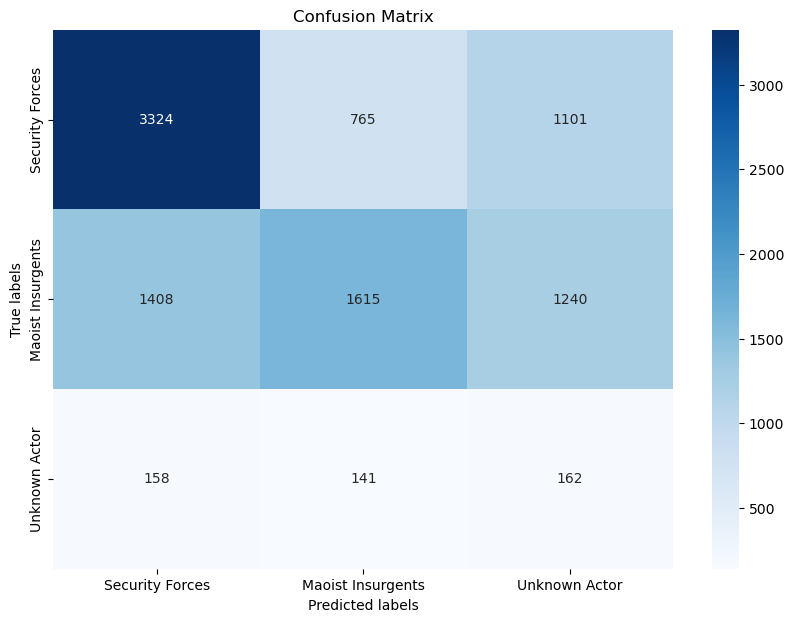

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(satp_df['original_label'], satp_df['predicted_label'])
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(satp_df['original_label'], satp_df['predicted_label'])

# Print confusion matrix
print(conf_matrix)

# Plot confusion matrix
confusion_labels = ["Security Forces", "Maoist Insurgents", "Unknown Actor"]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=confusion_labels, yticklabels=confusion_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Export the data for the zero shot model

In [13]:
# Assuming satp_df is your updated DataFrame
satp_df.to_csv('data/satp_zero_shot.csv', index=False, columns=['incident_number', 'incident_summary', 'predicted_label', 'confidence', 'original_label'])